In [1]:
import sys, os
from fractions import Fraction
import pandas as pd
import seaborn as sns
from ms3 import transform, name2fifths, fifths2pc
sys.path.append(os.path.abspath('../python_scripts/'))
from data_types import ChordType, PitchType
from constants import TRIAD_REDUCTION

def vc(S):
    """Value counts & normalized column"""
    vc = S.value_counts(dropna=False)
    return pd.concat([vc, vc / vc.sum()], axis=1, keys=['counts', 'fraction'])

In [2]:
data = '../Data/sonatas_annotations/progressions'
csv_files = os.listdir(data)
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time  matched_duration annotation1_chord annotation2_chord dcml_label  \
01-1 0  0.00              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     1  0.25              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     2  0.50              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     3  0.75              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   
     4  1.00              0.25      F_MINOR_inv0      F_MINOR_inv0       f.i{   

        sps  vl tbt  binary  
01-1 0  0.0   0   0   False  
     1  0.0   0   0   False  
     2  0.0   0   0   False  
     3  0.0   0   0   False  
     4  0.0   0   0   False

**Percentage of diverging labels** (binary=True)

In [3]:
vc(D.binary)

,counts,fraction
False,23703,0.676262
True,11347,0.323738


### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [4]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.561696
True     0.438304
Name: binary, dtype: float64


In [5]:
df = D[D.binary] # select only diverging

**Overview Spectral Pitch distances**

count    3236.000000
mean        0.308979
std         0.276483
min         0.000000
25%         0.075772
50%         0.180520
75%         0.523707
max         0.961760
Name: sps, dtype: float64


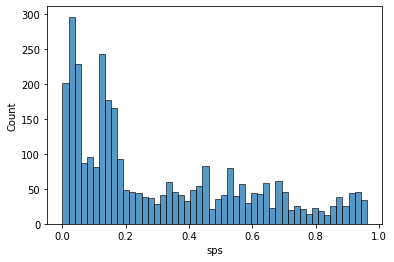

In [6]:
print(df.sps.describe())
sns.histplot(data=df, x='sps', bins=50);

**Overview Voice Leading distances**

count    3236.000000
mean        9.039246
std         6.245617
min         0.000000
25%         3.000000
50%         9.000000
75%        14.000000
max        24.000000
Name: vl, dtype: float64


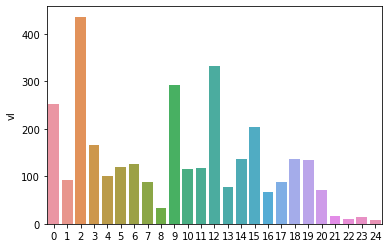

In [7]:
print(df.vl.describe())
vl = df.vl.value_counts()
sns.barplot(x=vl.index, y=vl);

**Overview tone-by-tone distances**

count    3236.000000
mean        0.528082
std         0.292171
min         0.125000
25%         0.285714
50%         0.428571
75%         0.857143
max         1.000000
Name: tbt, dtype: float64


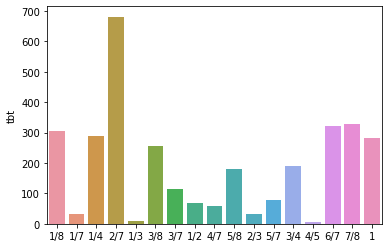

In [8]:
print(df.tbt.astype(float).describe())
tbt = df.tbt.value_counts()
sns.barplot(x=tbt.index, y=tbt);

## Expanding the data to inspect different categories of chord divergence

In [9]:
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
def is_triad(type_str):
    val = ChordType[type_str]
    return val.value < 4
df = D[D.binary]
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'triad': f"triad{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['triad'] = transform(expanded[2], is_triad)
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv')], axis=1)
df.pc_iv = df.pc_iv.where(df.pc_iv <= 6, 12 - df.pc_iv)
df.head()

time  matched_duration  annotation1_chord annotation2_chord  \
01-1 30   5.25             0.250  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2   
     43   7.25             0.250       C_MAJOR_inv0   C_MAJ_MIN7_inv0   
     56  10.25             0.375   Db_MAJ_MAJ7_inv3  Db_MAJ_MAJ7_inv1   
     87  16.00             0.250      Ab_MAJOR_inv1     Eb_MAJOR_inv0   
     95  18.00             0.250      Ab_MAJOR_inv1     Eb_MAJOR_inv0   

        dcml_label       sps  vl  tbt  binary root1  ... tpc1 pc1  root2  \
01-1 30     #viio6  0.049170   2  3/8    True     E  ...    4   4      C   
     43      V(4)}  0.273761   3  1/4    True     C  ...    0   0      C   
     56   III.IVM2  0.075546  15  1/4    True    Db  ...   -5   1     Db   
     87        I6{  0.447499  12  6/7    True    Ab  ...   -4   8     Eb   
     95        I6{  0.447499  12  6/7    True    Ab  ...   -4   8     Eb   

            type2  inv2 triad2 tpc2 pc2  tpc_iv  pc_iv  
01-1 30  MAJ_MIN7     2  False    0   0       4      4  
     43  MAJ_MIN7     0  False    0   0       0      0  
     56  MAJ_MAJ7     1  False   -5   1       0      0  
     87     MAJOR     0   True   -3   3       1      5  
     95     MAJOR     0   True   -3   3       1      5  

[5 rows x 23 columns]

In [10]:
same_root = df.tpc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2

### Inspecting chords diverging only by inversion
**Proportion of diverging chords that have the same root and type but different inversion (True)**

In [11]:
diverging_inv = same_root & same_type
vc(diverging_inv)

,counts,fraction
False,2548,0.787392
True,688,0.212608


In [12]:
inv_groups = df.loc[diverging_inv, ['inv1', 'inv2']]\
                 .apply(lambda row: tuple(sorted(row.astype(int))), axis=1)\
                 .rename('inversions')
inv_dist = inv_groups.map(lambda t: abs(t[0] - t[1])).rename('inv_dist')
different_inversions = pd.concat([df[diverging_inv], inv_groups, inv_dist], axis=1)
vc(different_inversions.inv_dist)

,counts,fraction
1,461,0.670058
2,183,0.265988
3,44,0.063953


In [13]:
different_inversions.groupby(['inv_dist', 'triad1', 'inversions']).size()

inv_dist  triad1  inversions
1         False   (0, 1)         35
                  (1, 2)         34
                  (2, 3)         50
          True    (0, 1)        293
                  (1, 2)         49
2         False   (0, 2)         43
                  (1, 3)         32
          True    (0, 2)        108
3         False   (0, 3)         44
dtype: int64

#### Tone by tone

In [14]:
vc(different_inversions.tbt)

,counts,fraction
2/7,440,0.639535
1/4,227,0.329942
3/8,7,0.010174
1/3,7,0.010174
3/7,6,0.008721
4/7,1,0.001453


In [15]:
different_inversions.groupby(['tbt', 'triad1', 'inversions']).size()

tbt  triad1  inversions
1/4  False   (0, 1)         33
             (0, 2)         38
             (0, 3)         43
             (1, 2)         32
             (1, 3)         31
             (2, 3)         50
2/7  True    (0, 1)        291
             (0, 2)        101
             (1, 2)         48
1/3  False   (0, 1)          1
             (0, 2)          4
             (0, 3)          1
             (1, 2)          1
3/8  False   (0, 1)          1
             (0, 2)          1
             (1, 2)          1
             (1, 3)          1
     True    (0, 2)          3
3/7  True    (0, 1)          1
             (0, 2)          4
             (1, 2)          1
4/7  True    (0, 1)          1
dtype: int64

**Grouping `tbt` values by combinations of inversions shows that all tetrads have the distance `1/4` and all triads the distance `2/7`** Note that the chords in question all share the same root.

#### Voice leading

In [16]:
vc(different_inversions.vl)

,counts,fraction
9,238,0.345930
12,224,0.325581
15,134,0.194767
18,37,0.053779
6,36,0.052326
16,9,0.013081
17,2,0.002907
19,2,0.002907
14,2,0.002907
5,1,0.001453


In [17]:
different_inversions.groupby(['vl', 'inv_dist', 'triad1']).size()

vl  inv_dist  triad1
5   1         True        1
6   3         False      36
7   1         False       1
9   1         False      89
              True      141
    3         False       8
10  1         False       1
11  1         True        1
12  1         False      26
              True      198
14  1         False       1
              True        1
15  2         False      38
              True       96
16  1         False       1
    2         False       3
              True        5
17  2         True        2
18  2         False      32
              True        5
19  2         False       2
dtype: int64

In [18]:
different_inversions.groupby(['inv_dist', 'triad1', 'type1', 'inversions', 'vl']).size()

inv_dist  triad1  type1       inversions  vl
1         False   DIM7        (0, 1)      9       4
                              (1, 2)      9       4
                              (2, 3)      9      11
                  HALF_DIM7   (1, 2)      9       2
                  MAJ_MIN7    (0, 1)      12     26
                                          14      1
                                          16      1
                              (1, 2)      7       1
                                          9      26
                                          10      1
                              (2, 3)      9      39
                  MIN_MIN7    (0, 1)      9       3
          True    DIMINISHED  (0, 1)      9      15
                              (1, 2)      9       2
                  MAJOR       (0, 1)      12    180
                                          14      1
                              (1, 2)      5       1
                                          9      28
                  M

In [19]:
different_inversions.groupby(['vl', 'type1', 'inversions']).size()

vl  type1       inversions
5   MAJOR       (1, 2)          1
6   MAJ_MIN7    (0, 3)         36
7   MAJ_MIN7    (1, 2)          1
9   DIM7        (0, 1)          4
                (0, 3)          8
                (1, 2)          4
                (2, 3)         11
    DIMINISHED  (0, 1)         15
                (1, 2)          2
    HALF_DIM7   (1, 2)          2
    MAJOR       (1, 2)         28
    MAJ_MIN7    (1, 2)         26
                (2, 3)         39
    MINOR       (0, 1)         96
    MIN_MIN7    (0, 1)          3
10  MAJ_MIN7    (1, 2)          1
11  MINOR       (0, 1)          1
12  MAJOR       (0, 1)        180
    MAJ_MIN7    (0, 1)         26
    MINOR       (1, 2)         18
14  MAJOR       (0, 1)          1
    MAJ_MIN7    (0, 1)          1
15  MAJOR       (0, 2)         53
    MAJ_MAJ7    (1, 3)          1
    MAJ_MIN7    (0, 2)         37
    MINOR       (0, 2)         43
16  MAJOR       (0, 2)          2
    MAJ_MIN7    (0, 1)          1
                (0, 2

**`18` is among the highest values that the voice leading distance yiels, so it is rather surprising that chords with the same root and type shall get this value**

#### SPS

In [20]:
different_inversions.groupby(['type1', 'inversions', 'sps']).size().head(60)

type1       inversions  sps     
DIM7        (0, 1)      0.091002     1
                        0.130723     3
            (0, 2)      0.076837     1
                        0.189457     1
            (0, 3)      0.057999     1
                        0.118810     6
                        0.124679     1
            (1, 2)      0.019882     1
                        0.029056     1
                        0.091002     1
                        0.114036     1
            (1, 3)      0.076837     1
                        0.147762    10
                        0.162639     1
                        0.170808     1
            (2, 3)      0.020830     1
                        0.057999     1
                        0.111540     6
                        0.130723     1
                        0.140453     2
DIMINISHED  (0, 1)      0.024659     5
                        0.036015     1
                        0.130883     2
                        0.133508     1
                        0.15054

**Surprising to see such different distances for transpositionally identical chord combinations**
As an example, let's inspect all cases where both datasets have a diminished 7th chord on the same root, one in first, one in second inversion:

In [21]:
different_inversions[(different_inversions.type1 == 'DIM7') & (different_inversions.inversions == ('1', '2'))]

,,time,matched_duration,annotation1_chord,annotation2_chord,dcml_label,sps,vl,tbt,binary,root1,...,root2,type2,inv2,triad2,tpc2,pc2,tpc_iv,pc_iv,inversions,inv_dist


In [22]:
gb = different_inversions.groupby('triad1').sps
pd.concat([gb.min(), gb.max()], axis=1, keys=['min_sps', 'max_sps'])

,min_sps,max_sps
triad1,,
False,0.014908,0.320787
True,0.021957,0.470165


### Inspecting chords diverging only by type
**Proportion of diverging chords that have the same root and inversion but different type (True)**

In [23]:
diverging_type = same_root & same_inversion
vc(diverging_type)

,counts,fraction
False,2791,0.862485
True,445,0.137515


#### Tone by tone

In [24]:
type_groups = df.loc[diverging_type, ['type1', 'type2']]\
                 .apply(lambda row: tuple(sorted(row)), axis=1)\
                 .rename('types')
triad_groups = df.loc[diverging_type, ['triad1', 'triad2']]\
                 .apply(lambda row: tuple(sorted(row)), axis=1)\
                 .rename('triads')
different_types = pd.concat([df[diverging_type], type_groups, triad_groups], axis=1)
vc(different_types.tbt)

,counts,fraction
1/8,305,0.685393
1/4,49,0.110112
3/8,40,0.089888
1/7,33,0.074157
3/7,8,0.017978
1/2,4,0.008989
4/7,4,0.008989
5/8,2,0.004494


In [25]:
different_types.groupby(['tbt', 'triads', 'inv1']).size()

tbt  triads          inv1
1/8  (False, False)  1         2
                     2         5
                     3         2
     (False, True)   0       206
                     1        76
                     2        14
1/7  (True, True)    0        16
                     1         7
                     2        10
1/4  (False, True)   0        36
                     1         9
     (True, True)    0         4
3/8  (False, False)  1         7
     (False, True)   0        31
     (True, True)    2         2
3/7  (False, True)   0         4
     (True, True)    1         4
1/2  (False, False)  1         2
     (False, True)   1         2
4/7  (True, True)    1         4
5/8  (False, True)   1         2
dtype: int64

In [26]:
different_types.groupby(['tbt', 'inv1', 'types']).size()

tbt  inv1  types                  
1/8  0     (DIM7, DIMINISHED)           7
           (DIMINISHED, HALF_DIM7)      6
           (MAJOR, MAJ_MAJ7)            2
           (MAJOR, MAJ_MIN7)          182
           (MINOR, MIN_MIN7)            9
     1     (DIM7, DIMINISHED)           6
           (DIM7, HALF_DIM7)            2
           (DIMINISHED, HALF_DIM7)      3
           (MAJOR, MAJ_MAJ7)            6
           (MAJOR, MAJ_MIN7)           58
           (MINOR, MIN_MIN7)            3
     2     (DIM7, DIMINISHED)           2
           (DIM7, HALF_DIM7)            4
           (MAJOR, MAJ_MIN7)           10
           (MAJ_MIN7, MIN_MIN7)         1
           (MINOR, MIN_MIN7)            2
     3     (HALF_DIM7, MIN_MIN7)        2
1/7  0     (DIMINISHED, MINOR)          1
           (MAJOR, MINOR)              15
     1     (AUGMENTED, MAJOR)           4
           (DIMINISHED, MINOR)          3
     2     (MAJOR, MINOR)              10
1/4  0     (MAJOR, MAJ_MIN7)           21

In [27]:
vc(different_types.vl)

,counts,fraction
2,272,0.611236
3,68,0.152809
1,52,0.116854
4,38,0.085393
5,9,0.020225
6,6,0.013483


In [28]:
different_types.groupby(['vl', 'triads', 'types']).size()

vl  triads          types                  
1   (False, False)  (DIM7, HALF_DIM7)            6
                    (HALF_DIM7, MIN_MIN7)        2
                    (MAJ_MIN7, MIN_MIN7)         1
    (False, True)   (MAJOR, MAJ_MAJ7)            8
                    (MAJOR, MAJ_MIN7)            2
    (True, True)    (AUGMENTED, MAJOR)           4
                    (DIMINISHED, MINOR)          4
                    (MAJOR, MINOR)              25
2   (False, True)   (DIMINISHED, HALF_DIM7)      9
                    (MAJOR, MAJ_MIN7)          246
                    (MINOR, MIN_MIN7)           14
    (True, True)    (MAJOR, MINOR)               3
3   (False, False)  (MAJ_MIN7, MIN_MIN7)         7
    (False, True)   (DIM7, DIMINISHED)          13
                    (MAJOR, MAJ_MIN7)           29
                    (MAJ_MIN7, MINOR)           14
    (True, True)    (MAJOR, MINOR)               5
4   (False, False)  (HALF_DIM7, MAJ_MIN7)        2
    (False, True)   (DIM7, MAJOR)     

#### SPS

In [29]:
different_types.sps.describe()

count    445.000000
mean       0.118570
std        0.161373
min        0.003718
25%        0.020821
50%        0.046492
75%        0.154695
max        0.713739
Name: sps, dtype: float64

In [30]:
different_types[different_types.sps > 0.4]

time  matched_duration   annotation1_chord annotation2_chord  \
05-1 396    69.00000           0.50000       Bb_MAJOR_inv0  Bb_MAJ_MIN7_inv0   
     674   124.50000           0.25000        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     1150  201.75000           0.50000        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
08-1 1277  167.50000           0.12500        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     1293  169.50000           0.12500        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     1339  175.50000           0.12500        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     1355  177.50000           0.12500        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
10-1 297    17.43750           0.06250        E_MAJOR_inv0   E_MAJ_MIN7_inv0   
     445    25.43750           0.06250        A_MAJOR_inv0   A_MAJ_MIN7_inv0   
     461    26.43750           0.06250        A_MAJOR_inv0   A_MAJ_MIN7_inv0   
     477    27.43750           0.06250        A_MAJOR_inv0   A_MAJ_MIN7_inv0   
     493    28.43750           0.06250        A_MAJOR_inv0   A_MAJ_MIN7_inv0   
     1560   80.93750           0.06250        A_MAJOR_inv0   A_MAJ_MIN7_inv0   
16-1 821    78.81250           0.06250        Db_DIM7_inv0     Db_MAJOR_inv0   
     829    79.31250           0.06250        Db_DIM7_inv0     Db_MAJOR_inv0   
     837    79.81250           0.06250        Db_DIM7_inv0     Db_MAJOR_inv0   
     845    80.31250           0.06250        Db_DIM7_inv0     Db_MAJOR_inv0   
17-1 408    43.50000           0.12500        E_MAJOR_inv0   E_MAJ_MIN7_inv0   
     1275  173.50000           0.12500        A_MAJOR_inv0   A_MAJ_MIN7_inv0   
18-1 1492  155.25000           0.12500       Bb_MAJOR_inv0  Bb_MAJ_MIN7_inv0   
26-1 85      8.87500           0.12500   G_DIMINISHED_inv1   G_MAJ_MIN7_inv1   
     88      9.37500           0.12500   F_DIMINISHED_inv1      F_MAJOR_inv1   
     91      9.87500           0.12500  Eb_DIMINISHED_inv1     Eb_MAJOR_inv1   
     611   101.87500           0.12500   G_DIMINISHED_inv1   G_MAJ_MIN7_inv1   
     614   102.37500           0.12500   F_DIMINISHED_inv1      F_MAJOR_inv1   
     617   102.87500           0.12500  Eb_DIMINISHED_inv1     Eb_MAJOR_inv1   
     1089  187.00000           0.50000       Bb_MAJOR_inv0  Bb_MAJ_MIN7_inv0   
     1120  191.50000           0.25000       Bb_MAJOR_inv0  Bb_MAJ_MIN7_inv0   
     1214  203.50000           0.25000       Bb_MAJOR_inv0  Bb_MAJ_MIN7_inv0   
32-1 48      7.00000           0.03125         A_DIM7_inv0      A_MAJOR_inv0   
     313    30.03125           0.12500        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     315    30.28125           0.12500        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     324    31.03125           0.06250        G_MAJOR_inv0   G_MAJ_MIN7_inv0   
     726    60.03125           0.06250       Eb_MAJOR_inv0  Eb_MAJ_MIN7_inv0   

           dcml_label       sps  vl  tbt  binary root1  ... root2     type2  \
05-1 396        V(64)  0.445551   4  3/8    True    Bb  ...    Bb  MAJ_MIN7   
     674        V(64)  0.644643   4  3/8    True     G  ...     G  MAJ_MIN7   
     1150       V(64)  0.644643   4  3/8    True     G  ...     G  MAJ_MIN7   
08-1 1277    V(b9b64)  0.713739   5  3/8    True     G  ...     G  MAJ_MIN7   
     1293    V(b9b64)  0.713739   5  3/8    True     G  ...     G  MAJ_MIN7   
     1339    V(b9b64)  0.713739   5  3/8    True     G  ...     G  MAJ_MIN7   
     1355    V(b9b64)  0.713739   5  3/8    True     G  ...     G  MAJ_MIN7   
10-1 297      V(64)/V  0.456421   4  3/8    True     E  ...     E  MAJ_MIN7   
     445        V(64)  0.679884   4  3/8    True     A  ...     A  MAJ_MIN7   
     461         V(4)  0.437962   3  1/4    True     A  ...     A  MAJ_MIN7   
     477         V(4)  0.437962   3  1/4    True     A  ...     A  MAJ_MIN7   
     493        V(64)  0.679884   4  3/8    True     A  ...     A  MAJ_MIN7   
     1560     V(64)/V  0.679884   4  3/8    True     A  ...     A  MAJ_MIN7   
16-1 821         Ger7  0.460214   6  3/7    True    Db  ...    Db     MAJOR   
     829         Ger7  0.46021

### Filtering out tetrad-triad correspondence (e.g. M <-> Mm7)

In [31]:
def reduce_tetrad(type_str):
    val = ChordType[type_str]
    return TRIAD_REDUCTION[val]

same_type_reduced = transform(df.type1, reduce_tetrad) == transform(df.type2, reduce_tetrad)

In [32]:
diverging_type_reduced = diverging_type & ~same_type_reduced
vc(diverging_type_reduced)

,counts,fraction
False,3153,0.974351
True,83,0.025649


In [33]:
different_types_reduced = df[diverging_type_reduced]
vc(different_types_reduced.tbt).sort_index()

,counts,fraction
1/8,3,0.036145
1/7,33,0.397590
1/4,19,0.228916
3/8,10,0.120482
3/7,8,0.096386
1/2,4,0.048193
4/7,4,0.048193
5/8,2,0.024096


In [34]:
vc(different_types_reduced.vl).sort_index()

,counts,fraction
1,36,0.433735
2,3,0.036145
3,26,0.313253
4,9,0.108434
5,3,0.036145
6,6,0.072289


In [35]:
different_types_reduced.sps.describe()

count    83.000000
mean      0.234685
std       0.145796
min       0.024963
25%       0.112052
50%       0.214398
75%       0.337645
max       0.528248
Name: sps, dtype: float64

In [36]:
different_types_reduced.sort_values('sps').head(50)

time  matched_duration  annotation1_chord annotation2_chord  \
18-1 662    76.75000          0.062500   D_HALF_DIM7_inv3   D_MIN_MIN7_inv3   
     690    79.75000          0.062500   D_HALF_DIM7_inv3   D_MIN_MIN7_inv3   
03-1 752    73.00000          0.250000       G_MAJOR_inv2  G_AUGMENTED_inv2   
31-1 1097   57.50000          0.125000  F_DIMINISHED_inv0      F_MINOR_inv0   
08-1 752    95.50000          0.125000       F_MAJOR_inv2      F_MINOR_inv2   
     848   107.50000          0.125000       F_MAJOR_inv2      F_MINOR_inv2   
03-1 1972  207.00000          0.250000       C_MAJOR_inv2  C_AUGMENTED_inv2   
31-1 1217   67.18750          0.062500   Bb_MAJ_MIN7_inv1  Bb_MIN_MIN7_inv1   
32-1 1378  111.53125          0.062500       G_MAJOR_inv0      G_MINOR_inv0   
     858    69.28125          0.875000       G_MAJOR_inv0      G_MINOR_inv0   
03-1 1371  148.50000          0.125000       G_MINOR_inv0      G_MAJOR_inv0   
31-1 410    22.93750          0.062500    F_MAJ_MIN7_inv1   F_MIN_MIN7_inv1   
10-1 459    26.31250          0.062500    E_MAJ_MIN7_inv1   E_MIN_MIN7_inv1   
     475    27.31250          0.062500    E_MAJ_MIN7_inv1   E_MIN_MIN7_inv1   
32-1 36      5.25000          0.031250   Eb_MAJ_MIN7_inv1  Eb_MIN_MIN7_inv1   
08-1 2190  296.87500          0.093750    C_MIN_MIN7_inv2   C_MAJ_MIN7_inv2   
17-1 1127  150.25000          0.125000       D_MAJOR_inv2      D_MINOR_inv2   
     24      4.25000          0.125000       D_MAJOR_inv2      D_MINOR_inv2   
31-1 1065   55.87500          0.031250   E_AUGMENTED_inv1      E_MAJOR_inv1   
16-1 1085  112.12500          0.062500       E_MAJOR_inv0      E_MINOR_inv0   
21-1 924    77.00000          0.500000       E_MAJOR_inv0      E_MINOR_inv0   
06-1 1222   76.00000          0.062500       F_MINOR_inv0      F_MAJOR_inv0   
10-1 1722   89.81250          0.062500    A_MAJ_MIN7_inv1   A_MIN_MIN7_inv1   
     1738   90.81250          0.062500    A_MAJ_MIN7_inv1   A_MIN_MIN7_inv1   
21-1 3310  274.50000          0.041667   C_AUGMENTED_inv1      C_MAJOR_inv1   
26-1 615   102.50000          0.250000  F_DIMINISHED_inv1      F_MINOR_inv1   
     89      9.50000          0.250000  F_DIMINISHED_inv1      F_MINOR_inv1   
01-1 354    56.75000          0.125000      Bb_MINOR_inv2     Bb_MAJOR_inv2   
     369    58.75000          0.125000      Bb_MINOR_inv2     Bb_MAJOR_inv2   
23-1 2132  236.75000          0.500000  D_DIMINISHED_inv1      D_MINOR_inv1   
06-1 1664   99.37500          0.041667       F_MINOR_inv0      F_MAJOR_inv0   
     1634   98.37500          0.041667       F_MINOR_inv0      F_MAJOR_inv0   
31-1 294    14.12500          0.031250  Eb_AUGMENTED_inv1     Eb_MAJOR_inv1   
08-1 1893  257.50000          0.125000       C_MAJOR_inv2      C_MINOR_inv2   
     1989  269.50000          0.125000       C_MAJOR_inv2      C_MINOR_inv2   
     736    93.50000          0.125000       C_MAJOR_inv2      C_MINOR_inv2   
     832   105.50000          0.125000       C_MAJOR_inv2      C_MINOR_inv2   
32-1 346    32.40625          0.062500       C_MAJOR_inv1      C_MINOR_inv1   
21-1 1313  110.25000          0.083333       C_MINOR_inv1      C_MAJOR_inv1   
20-1 100    13.00000          0.125000       A_MINOR_inv1   A_MAJ_MIN7_inv1   
06-1 516    33.62500          0.500000       A_MINOR_inv0      A_MAJOR_inv0   
     514    33.12500          0.250000       A_MINOR_inv0      A_MAJOR_inv0   
08-1 2054  278.00000          0.125000   D_HALF_DIM7_inv1   D_MAJ_MIN7_inv1   
     2083  282.00000          0.125000   D_HALF_DIM7_inv1   D_MAJ_MIN7_inv1   
     1241  163.00000          0.125000       F_MINOR_inv0   F_MAJ_MIN7_inv0   
03-1 1355  146.50000          0.125000       D_MINOR_inv0      D_MAJOR_inv0   
     1411  153.50000          0.125000       D_MINOR_inv0   D_MAJ_MIN7_inv0   
16-1 295    36.12500          0.062500       B_MAJOR_inv0      B_MINOR_inv0   
     488    49.56250          0.125000       B_MAJOR_inv0      B_MINOR_inv0   
03-1 1385  150.25000          0.125000       D_MAJOR_inv1      D_M

### Inspecting chords diverging only by root
**Proportion of diverging chords that have the same type and inversion but different root (True)**

In [37]:
diverging_root = same_type & same_inversion
vc(diverging_root)

,counts,fraction
False,2958,0.914091
True,278,0.085909


**Divergence by fifths**

In [38]:
different_roots = df[diverging_root].copy()
vc(different_roots.tpc_iv)

,counts,fraction
1,120,0.431655
9,66,0.237410
3,26,0.093525
2,15,0.053957
5,13,0.046763
11,10,0.035971
6,10,0.035971
8,5,0.017986
4,5,0.017986
7,4,0.014388


In [39]:
different_roots[different_roots.tpc_iv == 11]

time  matched_duration  annotation1_chord   annotation2_chord  \
06-1 730    43.50000          0.041667  B_DIMINISHED_inv2  Gb_DIMINISHED_inv2   
07-1 1711  287.75000          0.500000      Gb_MAJOR_inv0        B_MAJOR_inv0   
     1719  291.75000          0.500000      Gb_MAJOR_inv0        B_MAJOR_inv0   
09-1 206    29.50000          0.125000      Gb_MAJOR_inv0        B_MAJOR_inv0   
     237    35.25000          0.250000       B_MAJOR_inv1       Gb_MAJOR_inv1   
24-1 46      5.25000          0.125000       B_MAJOR_inv0       Gb_MAJOR_inv0   
     679    57.25000          0.125000       B_MAJOR_inv0       Gb_MAJOR_inv0   
     953    84.75000          0.083333      Gb_MAJOR_inv0        B_MAJOR_inv0   
     975    86.75000          0.083333      Gb_MAJOR_inv0        B_MAJOR_inv0   
32-1 972    84.15625          0.062500       Gb_DIM7_inv0         B_DIM7_inv0   

          dcml_label       sps  vl  tbt  binary root1  ... tpc1 pc1  root2  \
06-1 730   #viio64/v  0.917814  20    1    True     B  ...    5  11     Gb   
07-1 1711       V/ii  0.699080  18  6/7    True    Gb  ...   -6   6      B   
     1719       V/ii  0.699080  18  6/7    True    Gb  ...   -6   6      B   
09-1 206          V{  0.699080  18  6/7    True    Gb  ...   -6   6      B   
     237          I6  0.657731  18  6/7    True     B  ...    5  11     Gb   
24-1 46           IV  0.699080  18  6/7    True     B  ...    5  11     Gb   
     679          IV  0.699080  18  6/7    True     B  ...    5  11     Gb   
     953       I(64)  0.163216  15  4/7    True    Gb  ...   -6   6      B   
     975       I(64)  0.163216  15  4/7    True    Gb  ...   -6   6      B   
32-1 972     viio7/V  0.852696  19    1    True    Gb  ...   -6   6      B   

                type2  inv2 triad2 tpc2 pc2  tpc_iv  pc_iv  
06-1 730   DIMINISHED     2   True   -6   6      11      5  
07-1 1711       MAJOR     0   True    5  11      11      5  
     1719       MAJOR     0   True    5  11      11      5  
09-1 206        MAJOR     0   True    5  11      11      5  
     237        MAJOR     1   True   -6   6      11      5  
24-1 46         MAJOR     0   True   -6   6      11      5  
     679        MAJOR     0   True   -6   6      11      5  
     953        MAJOR     0   True    5  11      11      5  
     975        MAJOR     0   True    5  11      11      5  
32-1 972         DIM7     0  False    5  11      11      5  

[10 rows x 23 columns]

**Divergence by semitones**

In [40]:
vc(different_roots.pc_iv)

,counts,fraction
5,130,0.467626
3,92,0.330935
2,19,0.068345
1,17,0.061151
4,10,0.035971
6,10,0.035971


In [41]:
vc(different_roots.tbt)

,counts,fraction
6/7,139,0.500000
1,44,0.158273
3/4,42,0.151079
7/8,32,0.115108
4/7,15,0.053957
5/7,3,0.010791
4/5,3,0.010791


In [42]:
vc(different_roots.vl).sort_index()

,counts,fraction
4,1,0.003597
5,13,0.046763
6,3,0.010791
10,14,0.050360
11,32,0.115108
12,63,0.226619
13,2,0.007194
14,6,0.021583
15,17,0.061151
16,5,0.017986


In [43]:
different_roots.sps.describe()

count    278.000000
mean       0.571609
std        0.206521
min        0.000000
25%        0.441636
50%        0.570282
75%        0.687949
max        0.961760
Name: sps, dtype: float64